In [3]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.signal import savgol_filter
from scipy.stats import linregress
sys.path.append(str(Path('.').absolute().parent))
from saturn_system import a_sat, m_sat, R_eq_saturn, J2_sat, J2_inner_satellites, J2_titan, m_saturn_kg, G, a_saturn
plt.rcParams['font.family'] = 'serif'

In [4]:
def get_init_and_final_ecc(iap_orbit):
    length = len(iap_orbit[:,1])
    return savgol_filter(iap_orbit[:,1], 101, 3)[[length//10, 9*length//10]]

In [5]:
def Q_over_k2(tau_a):
    n = np.sqrt(G*m_saturn_kg/a_sat['titan']**3)
    return 1.5*m_sat['titan'] * (a_sat['titan']/R_eq_saturn)**-5 * n * tau_a

In [6]:
dir_path = Path('/mnt/data-big/mgoldberg/satellites/titan_iapetus_capture/e_iap_0.03_sun')
print(list(dir_path.glob("*capture_tau_a*")))

[PosixPath('/mnt/data-big/mgoldberg/satellites/titan_iapetus_capture/e_iap_0.03_sun/titan_iapetus_capture_tau_a_1e+09.p'), PosixPath('/mnt/data-big/mgoldberg/satellites/titan_iapetus_capture/e_iap_0.03_sun/titan_iapetus_capture_tau_a_1e+10.p'), PosixPath('/mnt/data-big/mgoldberg/satellites/titan_iapetus_capture/e_iap_0.03_sun/titan_iapetus_capture_tau_a_3e+09.p')]


In [6]:
class SimulationResults():
    def __init__(self, path):
        self.tau_a = float(path.stem.split('_')[-1])
        results = pickle.load(open(path, 'rb'))
        self.titan_orbits = []
        self.iap_orbits = []
        for result in results:
            self.times = result[0]
            self.titan_orbits.append(result[1])
            self.iap_orbits.append(result[2])
        self.results_df = pd.DataFrame([[self.tau_a, np.round(titan_orbit[0,1], 4), *get_init_and_final_ecc(iap_orbit), np.max(iap_orbit[:,1])] for titan_orbit, iap_orbit in self],
                                columns=['tau_a', 'e_titan', 'e_iap_init', 'e_iap_final', 'e_iap_max'])
        self.results_df['e_iap_diff'] = np.abs(self.results_df['e_iap_final'] - self.results_df['e_iap_init'])
        self.results_df_stable = self.results_df[self.results_df['e_iap_final'] < 1]

    def __len__(self):
        return len(self.titan_orbits)
    
    def __getitem__(self, idx):
        return self.titan_orbits[idx], self.iap_orbits[idx]

    def get_init_and_final_ecc(self, idx):
        length = len(self.titan_orbits[idx][:,1])
        return savgol_filter(self.titan_orbits[idx][:,1], 101, 3)[[length//10, 9*length//10]]


In [7]:
results = {}
for path in dir_path.glob("*capture_tau_a*"):
    temp_results = SimulationResults(path)
    results[temp_results.tau_a] = temp_results
results = dict(sorted(results.items(), key=lambda item: item[0]))
results_df = pd.concat([results[tau_a].results_df for tau_a in results], ignore_index=True)

In [8]:
for tau_a, result in results.items():
    print(f'{tau_a:.0e}', f'{result.times[-1]+1e3:0g}', len(result))

1e+09 5e+06 30
3e+09 1.5e+07 30
1e+10 5e+07 30


Titan eccentricity: 0.030
Iapetus eccentricity: 0.030
inc_L = 15.946035966728196


/tmp/ipykernel_4020329/2081735256.py:17: RuntimeWarning: invalid value encountered in arccos
  Omega_L = np.arccos((np.cos(inc_L)*np.cos(inc_to_laplace) - np.cos(iap_orbit[:,2]))/(np.sin(inc_L)*np.sin(inc_to_laplace)))


Text(0.5, 0, 'Time [Myr]')

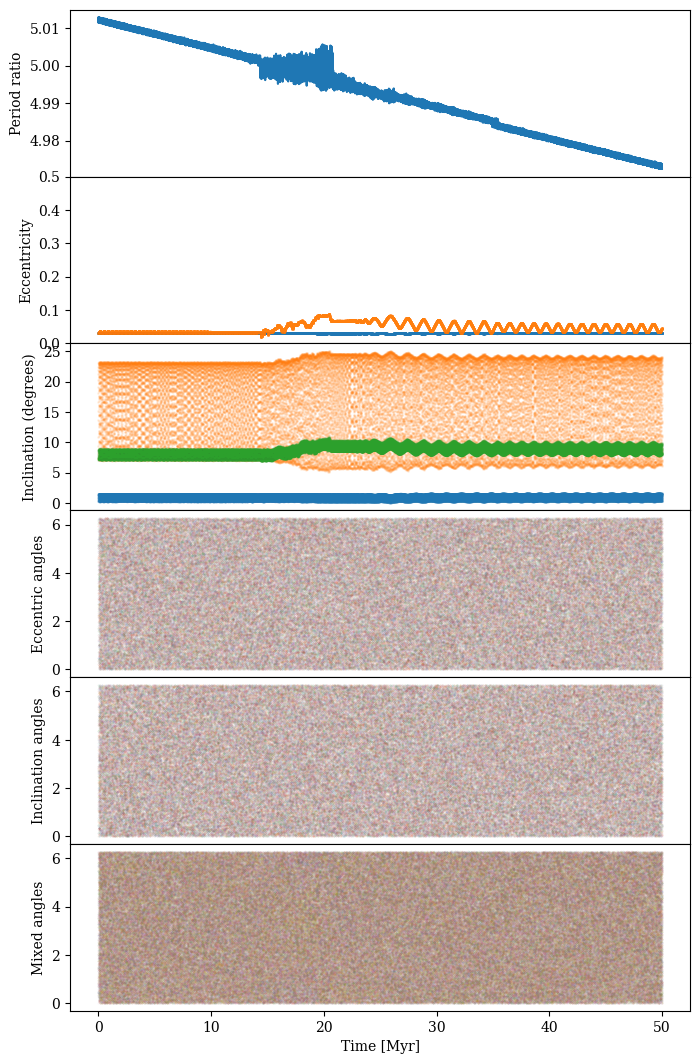

In [14]:
result = results[1e10]
idx = 11
titan_orbit, iap_orbit = result[idx]
times = result.times
print('Titan eccentricity: {:.3f}'.format(titan_orbit[0,1]))
print('Iapetus eccentricity: {:.3f}'.format(iap_orbit[0,1]))
solar_inc = np.radians(26.7)
solar_Omega = np.radians(0)
solar_m = 3499
r_L = ((J2_sat + J2_inner_satellites + J2_titan)*R_eq_saturn**2*a_saturn**3/solar_m)**(1/5)
inc_L = np.arctan(np.sin(2*solar_inc)/(np.cos(2*solar_inc) + 2*r_L**5/a_sat['iapetus']**5))/2
print('inc_L =', np.degrees(inc_L))
# iap_normal = np.array([np.sin(iap_orbit[:,4])*np.sin(iap_orbit[:,2]), -np.cos(iap_orbit[:,4])*np.sin(iap_orbit[:,2]), np.cos(iap_orbit[:,2])]).T
# laplace_normal = np.array([np.sin(solar_Omega)*np.sin(inc_L), -np.cos(solar_Omega)*np.sin(inc_L), np.cos(inc_L)]).T
# inc_to_laplace = np.arccos(np.sum(iap_normal*laplace_normal, axis=1))
inc_to_laplace = np.arccos(np.cos(inc_L)*np.cos(iap_orbit[:,2]) + np.sin(inc_L)*np.sin(iap_orbit[:,2])*np.cos(iap_orbit[:,4] - solar_Omega))
Omega_L = np.arccos((np.cos(inc_L)*np.cos(inc_to_laplace) - np.cos(iap_orbit[:,2]))/(np.sin(inc_L)*np.sin(inc_to_laplace)))
fig, axs = plt.subplots(6, 1, figsize=(8, 13), sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(times/1e6, (iap_orbit[:,0]/titan_orbit[:,0])**1.5)
axs[0].set_ylabel('Period ratio')
axs[1].scatter(times/1e6, titan_orbit[:,1], label='Titan', s=1, alpha=0.1)
# axs[1].scatter(times/1e6, iap_orbit[:,1], label='Iapetus', s=1, alpha=0.1)
axs[1].scatter(times/1e6, savgol_filter(iap_orbit[:,1], 101, 3), label='Iapetus', s=1, alpha=0.1)
axs[1].set_ylim(0, 0.5)
axs[1].set_ylabel('Eccentricity')
axs[2].scatter(times/1e6, np.degrees(titan_orbit[:,2]), label='Titan', s=1, alpha=0.1)
axs[2].scatter(times/1e6, np.degrees(iap_orbit[:,2]), label='Iapetus', s=1, alpha=0.1)
axs[2].scatter(times/1e6, np.degrees(inc_to_laplace), label='Iapetus to Laplace', s=1, alpha=0.1)
axs[2].set_ylabel('Inclination (degrees)')

ecc_angle_coeffs = np.array([[5, -1, -4, -0, 0, 0], 
                             [5, -1, -3, -1, 0, 0], 
                             [5, -1, -2, -2, 0, 0],
                             [5, -1, -1, -3, 0, 0],
                             [5, -1, -0, -4, 0, 0]])

incl_angle_coeffs = np.array([[5, -1, 0, 0, -4, -0],
                              [5, -1, 0, 0, -3, -1],
                              [5, -1, 0, 0, -2, -2],
                              [5, -1, 0, 0, -1, -3],
                              [5, -1, 0, 0, -0, -4]])

mixed_angle_coeffs = np.array([[5, -1, -2, -0, -2, -0],
                               [5, -1, -1, -1, -2, -0],
                               [5, -1, -0, -2, -2, -0],
                               [5, -1, -2, -0, -1, -1],
                               [5, -1, -1, -1, -1, -1],
                               [5, -1, -0, -2, -1, -1],
                               [5, -1, -2, -0, -0, -2],
                               [5, -1, -1, -1, -0, -2],
                               [5, -1, -0, -2, -0, -2]])

angles_array = np.array([iap_orbit[:,5], titan_orbit[:,5], titan_orbit[:,3], iap_orbit[:,3], titan_orbit[:,4],  iap_orbit[:,4]])
ecc_angles = np.remainder(ecc_angle_coeffs @ angles_array, 2*np.pi)
incl_angles = np.remainder(incl_angle_coeffs @ angles_array, 2*np.pi)
mixed_angles = np.remainder(mixed_angle_coeffs @ angles_array, 2*np.pi)
for ecc_angle in ecc_angles:
    axs[3].scatter(times/1e6, ecc_angle, s=.1, alpha=0.1)
axs[3].set_ylabel('Eccentric angles')
for incl_angle in incl_angles:
    axs[4].scatter(times/1e6, incl_angle, s=.1, alpha=0.1)
axs[4].set_ylabel('Inclination angles')
for mixed_angle in mixed_angles:
    axs[5].scatter(times/1e6, mixed_angle, s=.1, alpha=0.1)
axs[5].set_ylabel('Mixed angles')
axs[5].set_xlabel('Time [Myr]')
# axs[5].set_xlim(0.15, 0.17)

In [10]:
grouped = results_df.groupby(['tau_a', 'e_titan'])
grouped.agg(['median', 'sem'])['e_iap_max']

median           sem
tau_a        e_titan                        
1.000000e+09 0.005    0.034974  1.705121e-03
             0.030    0.036188  2.186613e-03
             0.050    0.048319  4.871145e-03
3.000000e+09 0.005    0.033334  2.434975e-03
             0.030    0.038723  1.084844e+04
             0.050    0.047254  1.135631e-02
1.000000e+10 0.005    0.046312  1.742429e-02
             0.030    0.092203  5.388239e+07
             0.050    0.102092  3.740580e+07

In [11]:
cum_results = results_df.groupby(['tau_a', 'e_titan']).agg(lambda x: np.mean(x < 1, axis=0))['e_iap_max']
cum_results.unstack()

e_titan,0.005,0.030,0.050
tau_a,,,
1.000000e+09,1.0,1.0,1.0
3.000000e+09,1.0,0.9,1.0
1.000000e+10,1.0,0.9,0.8


(0.0, 0.15)

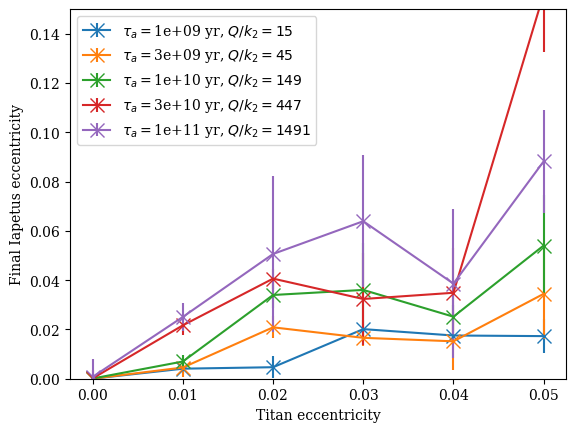

In [70]:
for i, result in enumerate(results.values()):
    grouped = result.results_df_stable.groupby('e_titan')
    grouped.filter
    plt.errorbar(grouped['e_titan'].mean(), grouped['e_iap_final'].median(), yerr=grouped['e_iap_final'].sem(),
                 label=rf'$\tau_a=${result.tau_a:.2g} yr, $Q/k_2={Q_over_k2(result.tau_a):.0f}$', markersize=10, linestyle=None, marker='x')
plt.xlabel('Titan eccentricity')
plt.ylabel('Final Iapetus eccentricity')
plt.legend()
plt.ylim(0, 0.15)
# plt.yscale('log')

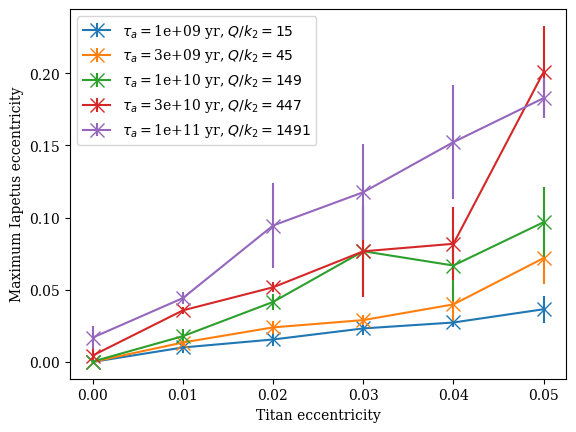

In [71]:
for i, result in enumerate(results.values()):
    grouped = result.results_df_stable.groupby('e_titan')
    plt.errorbar(grouped['e_titan'].mean(), grouped['e_iap_max'].mean(), yerr=grouped['e_iap_max'].sem(),
                 label=rf'$\tau_a=${result.tau_a:.2g} yr, $Q/k_2={Q_over_k2(result.tau_a):.0f}$', markersize=10, linestyle=None, marker='x')
plt.xlabel('Titan eccentricity')
plt.ylabel('Maximum Iapetus eccentricity')
plt.legend()
# plt.yscale('log')

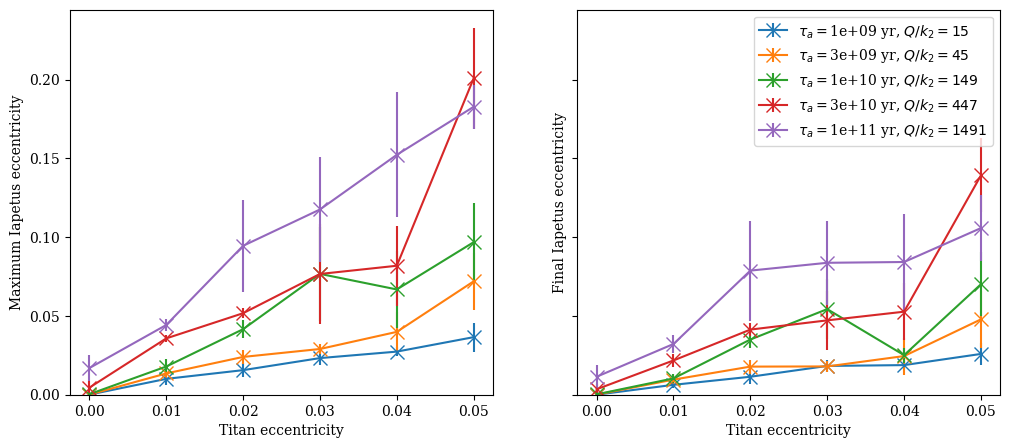

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
for i, result in enumerate(results.values()):
    grouped = result.results_df_stable.groupby('e_titan')
    axs[0].errorbar(grouped['e_titan'].mean(), grouped['e_iap_max'].mean(), yerr=grouped['e_iap_max'].sem(),
                 label=rf'$\tau_a=${result.tau_a:.2g} yr, $Q/k_2={Q_over_k2(result.tau_a):.0f}$', markersize=10, linestyle=None, marker='x')
    axs[1].errorbar(grouped['e_titan'].mean(), grouped['e_iap_final'].mean(), yerr=grouped['e_iap_final'].sem(),
                 label=rf'$\tau_a=${result.tau_a:.2g} yr, $Q/k_2={Q_over_k2(result.tau_a):.0f}$', markersize=10, linestyle=None, marker='x')
axs[0].set_xlabel('Titan eccentricity')
axs[1].set_xlabel('Titan eccentricity')
axs[0].set_ylabel('Maximum Iapetus eccentricity')
axs[1].set_ylabel('Final Iapetus eccentricity')
axs[0].set_ylim(0, None)
plt.legend()
# plt.yscale('log')

Text(0, 0.5, 'Power law index of eccentricity change vs. migration rate')

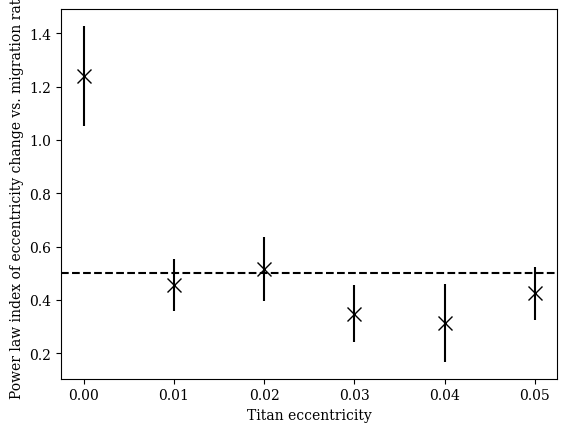

In [73]:
for name, group in pd.concat(result.results_df_stable for result in results.values()).groupby('e_titan'):
    linreg = linregress(np.log10(group['tau_a']), np.log10(group['e_iap_diff']))
    plt.errorbar([name], [linreg.slope], yerr=linreg.stderr, marker='x', markersize=10, linestyle=None, c='k')
plt.axhline(0.5, linestyle='--', c='k')
plt.xlabel('Titan eccentricity')
plt.ylabel('Power law index of eccentricity change vs. migration rate')

In [81]:
10**(2*(linreg.intercept+3.3))

2.7442107642735284e-05

In [90]:
Q_over_k2(1e10)

149.09756214191572

(0.0, 0.2)

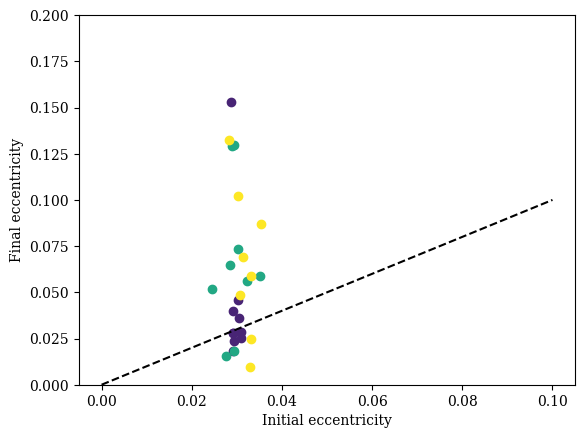

In [94]:
for titan_orbit, iap_orbit in results[1e10]:
    plt.scatter(*get_init_and_final_ecc(iap_orbit), c=titan_orbit[0,1], cmap='viridis', vmin=0, vmax=0.05)
plt.plot([0, 0.1], [0, 0.1], c='k', ls='--')
plt.xlabel('Initial eccentricity')
plt.ylabel('Final eccentricity')
plt.ylim(0, 0.2)